In [1]:
using Distributions
using StatsPlots

In [2]:
function logtick(; xlim=(0.03, 30))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    nums =     [1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = Bool[1, 1, 0, 0, 1, 0, 0, 0, 0]
    
    logtick = foldl(vcat, ([10.0^k*x for x in nums if xmin ≤ 10.0^k*x ≤ xmax] for k in a:b))
    logticklabel_a = foldl(vcat,
        ([mask[i] ? string(round(10.0^k*x; digits=-k)) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in a:-1))
    logticklabel_b = foldl(vcat,
        ([mask[i] ? string(10^k*x) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in 0:b))
    logticklabel = vcat(logticklabel_a, logticklabel_b)
    (logtick, logticklabel)
end

logtick()

([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.30000000000000004  …  3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0], ["", "", "0.05", "", "", "", "", "0.1", "0.2", ""  …  "", "", "5", "", "", "", "", "10", "20", ""])

In [3]:
function pvalue_clopper_pearson(model::DiscreteUnivariateDistribution, data)
    min(1, 2cdf(model, data), 2ccdf(model, data-1))
end

function pvalue_fisher_clopper_pearson(a, b, c, d; ω = 1)
    if ω == 1
        model = Hypergeometric(a+b, c+d, a+c)
    else
        model = FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_clopper_pearson(model, a)
end 

x ⪅ y = x < y || x ≈ y

function pvalue_sterne(model::DiscreteUnivariateDistribution, data)
    p0 = pdf(model, data)
    p0 == 0 && return 0.0
    p0 == 1 && return 1.0
    m = mode(model)
    pdf(model, m) ≈ p0 && return 1.0
    if data > m
        i = m - 1
        while !(pdf(model, i) ⪅ p0) i -= 1 end
        return cdf(model, i) + ccdf(model, data-1)
    else # data < m
        i = m + 1
        while !(pdf(model, i) ⪅ p0) i += 1 end
        return cdf(model, data) + ccdf(model, i-1)
    end
end

function pvalue_fisher_sterne(a, b, c, d; ω = 1)
    if ω == 1
        model = Hypergeometric(a+b, c+d, a+c)
    else
        model = FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(model, a)
end 

pvalue_fisher_sterne (generic function with 1 method)

In [4]:
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [5]:
@show pvalue_fisher_clopper_pearson(0, 15, 2, 0)
@show pvalue_fisher_sterne(0, 15, 2, 0)
@show pvalue_or_pearson_chisq(0, 15, 2, 0);

pvalue_fisher_clopper_pearson(0, 15, 2, 0) = 0.014705882352941168
pvalue_fisher_sterne(0, 15, 2, 0) = 0.007352941176470584
pvalue_or_pearson_chisq(0, 15, 2, 0) = 3.737981840170161e-5


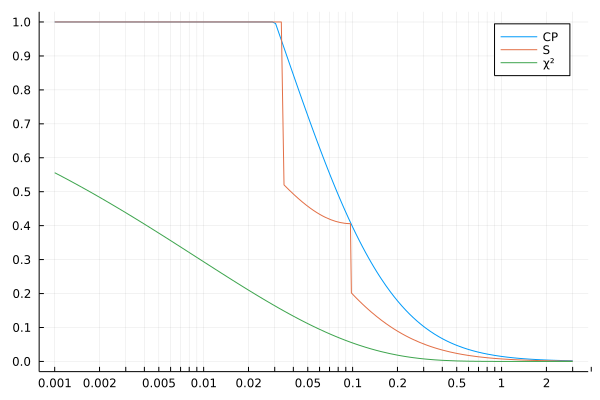

In [6]:
plot()
plot!(ω -> pvalue_fisher_clopper_pearson(0, 15, 2, 0; ω), 0.001, 3; label="CP")
plot!(ω -> pvalue_fisher_sterne(0, 15, 2, 0; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(0, 15, 2, 0; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.001, 10)))

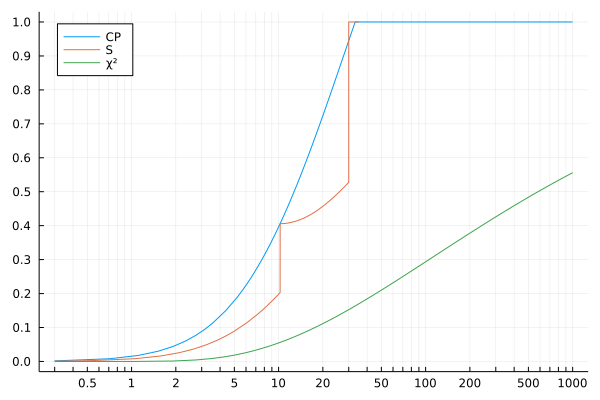

In [7]:
plot(legend=:topleft)
plot!(ω -> pvalue_fisher_clopper_pearson(15, 0, 0, 2; ω), 0.3, 1000; label="CP")
plot!(ω -> pvalue_fisher_sterne(15, 0, 0, 2; ω), 0.3, 35; label="S")
plot!(ω -> pvalue_or_pearson_chisq(15, 0, 0, 2; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.3, 1000)))

https://mobile.twitter.com/subsub99999/status/1548293633623064576

(a, b, c, d) = (7, 1182, 2, 811)
pvalue_fisher_clopper_pearson(a, b, c, d) = 0.4398562959899008
pvalue_fisher_sterne(a, b, c, d) = 0.3257190127661149
pvalue_or_pearson_chisq(a, b, c, d) = 0.26027090050066687


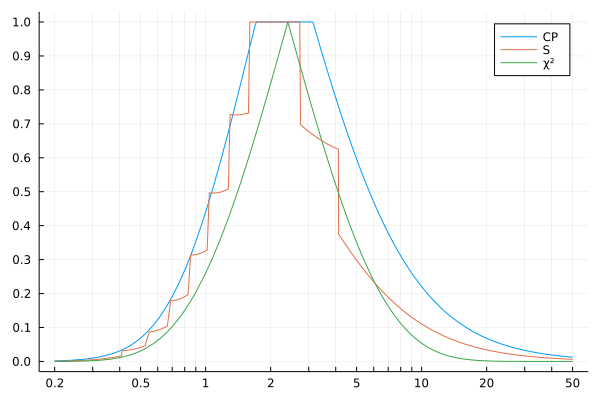

In [8]:
m, a, n, c = 1189, 7, 813, 2
b, d = m-a, n-c
@show a, b, c, d
@show pvalue_fisher_clopper_pearson(a, b, c, d)
@show pvalue_fisher_sterne(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)

plot()
plot!(ω -> pvalue_fisher_clopper_pearson(a, b, c, d; ω), 0.2, 50; label="CP")
plot!(ω -> pvalue_fisher_sterne(a, b, c, d; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.2, 50)))

(a, b, c, d) = (1, 3365, 2, 811)
pvalue_fisher_clopper_pearson(a, b, c, d) = 0.19749505692255276
pvalue_fisher_sterne(a, b, c, d) = 0.09874752846127638
pvalue_or_pearson_chisq(a, b, c, d) = 0.03877863766475411


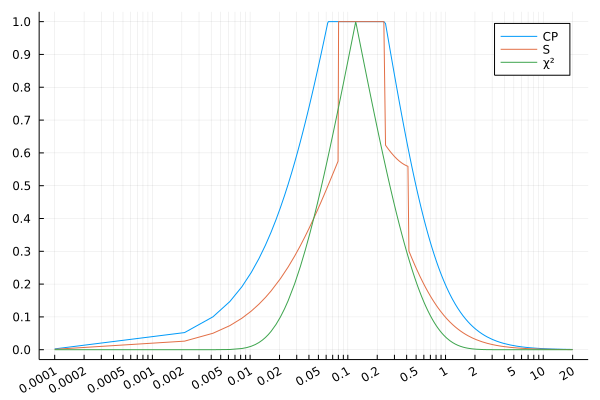

In [9]:
m, a, n, c = 3366, 1, 813, 2
b, d = m-a, n-c
@show a, b, c, d
@show pvalue_fisher_clopper_pearson(a, b, c, d)
@show pvalue_fisher_sterne(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)

plot()
plot!(ω -> pvalue_fisher_clopper_pearson(a, b, c, d; ω), 0.0001, 20; label="CP")
plot!(ω -> pvalue_fisher_sterne(a, b, c, d; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.0001, 20)), xrotation=30)

(a, b, c, d) = (1, 2943, 0, 207)
pvalue_fisher_clopper_pearson(a, b, c, d) = 1.0
pvalue_fisher_sterne(a, b, c, d) = 1.0
pvalue_or_pearson_chisq(a, b, c, d) = 0.7908499031109096


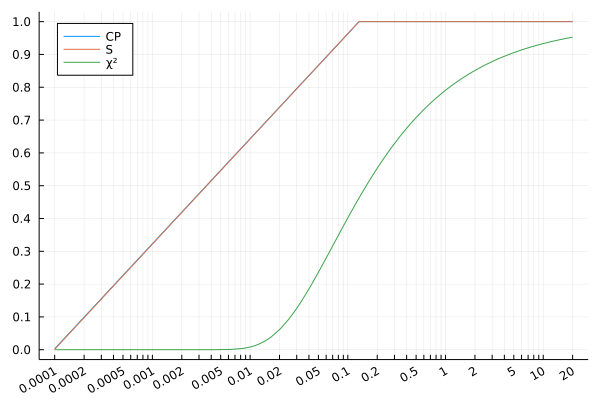

In [12]:
m, a, n, c = 2944, 1, 207, 0
b, d = m-a, n-c
@show a, b, c, d
@show pvalue_fisher_clopper_pearson(a, b, c, d)
@show pvalue_fisher_sterne(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)

plot(legend=:topleft)
plot!(ω -> pvalue_fisher_clopper_pearson(a, b, c, d; ω), 0.0001, 20; label="CP")
plot!(ω -> pvalue_fisher_sterne(a, b, c, d; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.0001, 20)), xrotation=30)

(a, b, c, d) = (3, 3423, 0, 207)
pvalue_fisher_clopper_pearson(a, b, c, d) = 1.0
pvalue_fisher_sterne(a, b, c, d) = 1.0
pvalue_or_pearson_chisq(a, b, c, d) = 0.6701636586351863


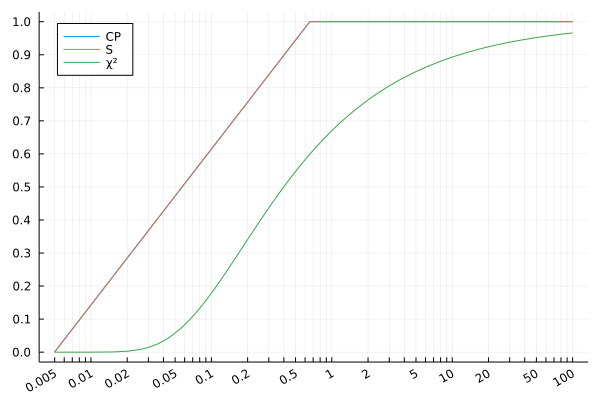

In [21]:
m, a, n, c = 3426, 3, 207, 0
b, d = m-a, n-c
@show a, b, c, d
@show pvalue_fisher_clopper_pearson(a, b, c, d)
@show pvalue_fisher_sterne(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)

plot(legend=:topleft)
plot!(ω -> pvalue_fisher_clopper_pearson(a, b, c, d; ω), 0.005, 100; label="CP")
plot!(ω -> pvalue_fisher_sterne(a, b, c, d; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.005, 100)), xrotation=30)

(a, b, c, d) = (5, 1148, 1, 1163)
pvalue_fisher_clopper_pearson(a, b, c, d) = 0.21372727242346493
pvalue_fisher_sterne(a, b, c, d) = 0.12283603212607436
pvalue_or_pearson_chisq(a, b, c, d) = 0.09960444930607301


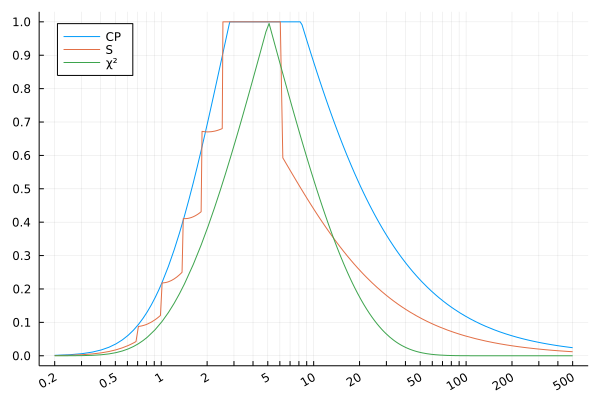

In [20]:
m, a, n, c = 1153, 5, 1164, 1
b, d = m-a, n-c
@show a, b, c, d
@show pvalue_fisher_clopper_pearson(a, b, c, d)
@show pvalue_fisher_sterne(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)

plot(legend=:topleft)
plot!(ω -> pvalue_fisher_clopper_pearson(a, b, c, d; ω), 0.2, 500; label="CP")
plot!(ω -> pvalue_fisher_sterne(a, b, c, d; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.2, 500)), xrotation=30)

(a, b, c, d) = (7, 3708, 1, 1163)
pvalue_fisher_clopper_pearson(a, b, c, d) = 0.7920332409663169
pvalue_fisher_sterne(a, b, c, d) = 0.689160413826347
pvalue_or_pearson_chisq(a, b, c, d) = 0.4506596398383987


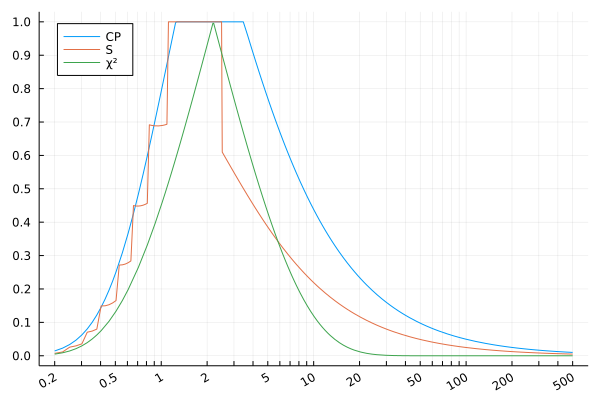

In [22]:
m, a, n, c = 3715, 7, 1164, 1
b, d = m-a, n-c
@show a, b, c, d
@show pvalue_fisher_clopper_pearson(a, b, c, d)
@show pvalue_fisher_sterne(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)

plot(legend=:topleft)
plot!(ω -> pvalue_fisher_clopper_pearson(a, b, c, d; ω), 0.2, 500; label="CP")
plot!(ω -> pvalue_fisher_sterne(a, b, c, d; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.2, 500)), xrotation=30)

(a, b, c, d) = (70, 13640, 65, 6143)
pvalue_fisher_clopper_pearson(a, b, c, d) = 5.24884029653111e-5
pvalue_fisher_sterne(a, b, c, d) = 3.562440333991962e-5
pvalue_or_pearson_chisq(a, b, c, d) = 1.9193599037140927e-5


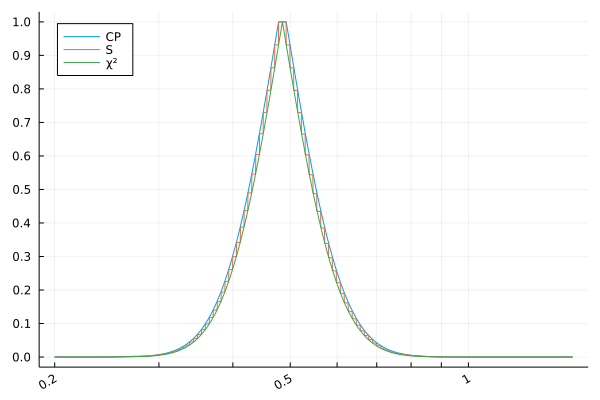

In [26]:
m, a, n, c = 13710, 70, 6208, 65
b, d = m-a, n-c
@show a, b, c, d
@show pvalue_fisher_clopper_pearson(a, b, c, d)
@show pvalue_fisher_sterne(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)

plot(legend=:topleft)
plot!(ω -> pvalue_fisher_clopper_pearson(a, b, c, d; ω), 0.2, 1.5; label="CP")
plot!(ω -> pvalue_fisher_sterne(a, b, c, d; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.2, 5)), xrotation=30)

(a, b, c, d) = (99, 17657, 65, 6143)
pvalue_fisher_clopper_pearson(a, b, c, d) = 0.00015769080075413985
pvalue_fisher_sterne(a, b, c, d) = 0.00010937380058293333
pvalue_or_pearson_chisq(a, b, c, d) = 5.6561464800920445e-5


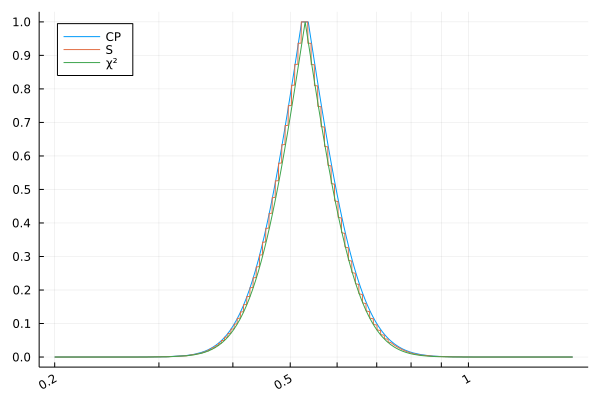

In [27]:
m, a, n, c = 17756, 99, 6208, 65
b, d = m-a, n-c
@show a, b, c, d
@show pvalue_fisher_clopper_pearson(a, b, c, d)
@show pvalue_fisher_sterne(a, b, c, d)
@show pvalue_or_pearson_chisq(a, b, c, d)

plot(legend=:topleft)
plot!(ω -> pvalue_fisher_clopper_pearson(a, b, c, d; ω), 0.2, 1.5; label="CP")
plot!(ω -> pvalue_fisher_sterne(a, b, c, d; ω); label="S")
plot!(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω); label="χ²")
plot!(ytick=0:0.1:1)
plot!(xscale=:log10, xtick=logtick(xlim=(0.2, 5)), xrotation=30)